In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

In [62]:
df = pd.read_csv("HR_data.csv") 
maps = {
    "Cohort": {"D1_1": 1, "D1_2": 2},
    "Round":  {"round_1": 1, "round_2": 2, "round_3": 3, "round_4": 4},
    "Phase":  {"phase1": 1, "phase2": 2, "phase3": 3},
}
for col, mp in maps.items():
    df[col] = df[col].map(mp)

In [63]:
features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC', 'Round', 'Phase', 'Individual', 'Puzzler', 'Frustrated', 'Cohort']
X = df[features]
y = df['Frustrated'].round().astype(int)  # Target as integer (classification)
groups = df['Individual']

In [64]:
lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))

In [65]:
gkf = GroupKFold(n_splits=5)

# Store results
acc_lr = []
acc_rf = []
f1_lr = []
f1_rf = []
cm_lr = np.zeros((11, 11))  # For 0-10 frustration scores
cm_rf = np.zeros((11, 11))

# Cross-validation loop
for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Logistic Regression
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr.append(accuracy_score(y_test, y_pred_lr))
    f1_lr.append(f1_score(y_test, y_pred_lr, average='macro'))
    cm_lr += confusion_matrix(y_test, y_pred_lr, labels=range(11))

    # Random Forest
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, y_pred_rf))
    f1_rf.append(f1_score(y_test, y_pred_rf, average='macro'))
    cm_rf += confusion_matrix(y_test, y_pred_rf, labels=range(11))

In [66]:
t_acc, p_acc = ttest_rel(acc_lr, acc_rf)
t_f1, p_f1 = ttest_rel(f1_lr, f1_rf)

In [67]:
print("Logistic Regression Accuracy:", acc_lr)
print("Random Forest Accuracy:", acc_rf)
print("Logistic Regression F1:", f1_lr)
print("Random Forest F1:", f1_rf)
print(f"Paired t-test on accuracy: t = {t_acc:.3f}, p = {p_acc:.3f}")
print(f"Paired t-test on F1-score: t = {t_f1:.3f}, p = {p_f1:.3f}")

Logistic Regression Accuracy: [0.3888888888888889, 0.4444444444444444, 0.5833333333333334, 0.3055555555555556, 0.6666666666666666]
Random Forest Accuracy: [0.6944444444444444, 0.8333333333333334, 0.7777777777777778, 0.7222222222222222, 0.875]
Logistic Regression F1: [0.23866873866873867, 0.4093915343915344, 0.5483405483405484, 0.19945165945165944, 0.521581359816654]
Random Forest F1: [0.42948532948532947, 0.6238576238576238, 0.5816592033697296, 0.5383928571428571, 0.8055555555555555]
Paired t-test on accuracy: t = -6.683, p = 0.003
Paired t-test on F1-score: t = -4.098, p = 0.015


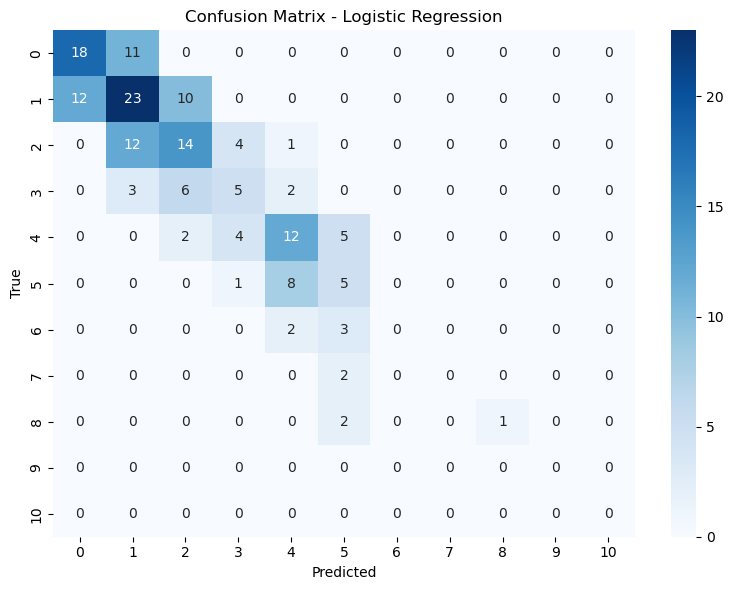

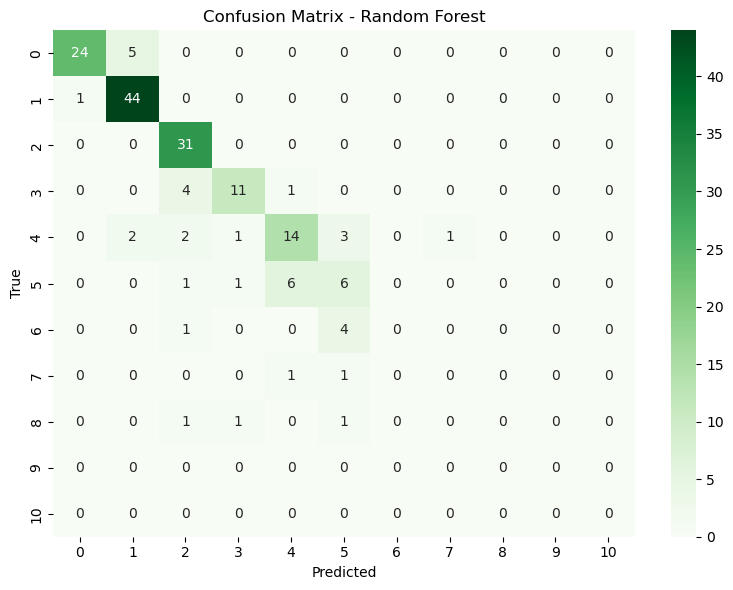

In [ ]:
# Ensure integer type
cm_lr = cm_lr.astype(int)
cm_rf = cm_rf.astype(int)

# Confusion Matrix - Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Confusion Matrix - Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
